# Skin Cancer Detection

## Importing libraries and reading dataset

In [1]:
import cv2
import os
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data_path = 'dataset/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'benign': 0, 'malignant': 1}
['benign', 'malignant']
[0, 1]


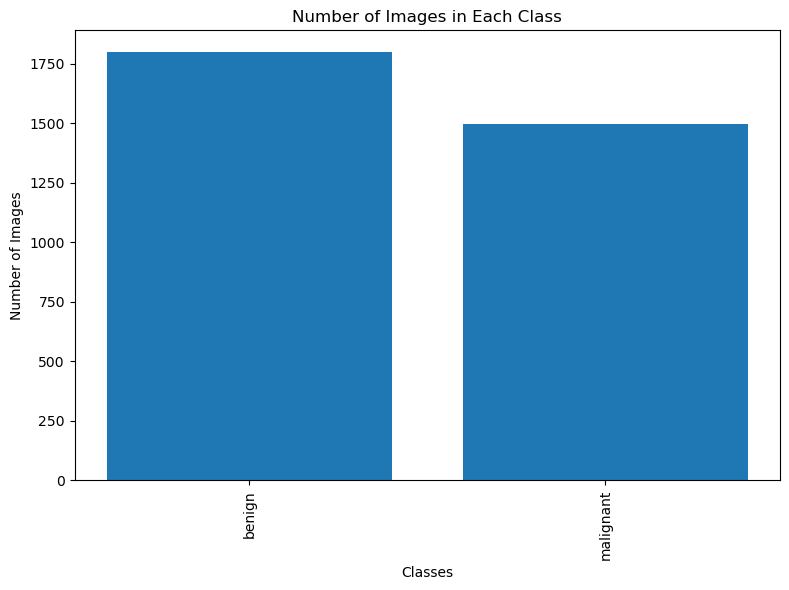

In [2]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(8, 6))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [3]:
img_size = 224
data = []
label = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            # resizing the image into 224x224, as required by ResNet50
            data.append(resized)
            label.append(label_dict[category])
            # appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:', e)
            # if any exception raised, the exception will be printed here. And pass to the next image

In [4]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)
new_label = to_categorical(label)

In [5]:
data.shape

(3297, 224, 224, 3)

## Splitting dataset into testing and training

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)

## Plotting sample of images

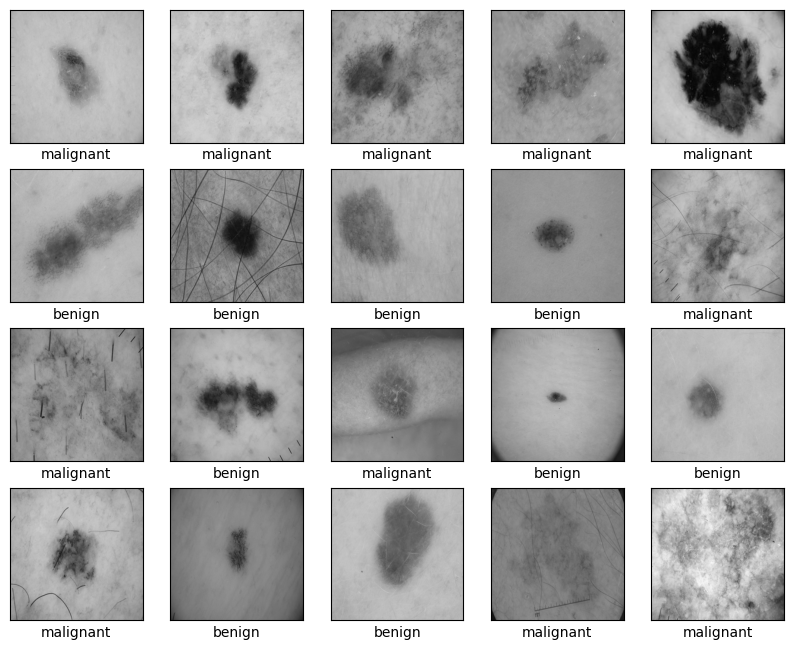

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

## VGG16

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,322,530 (62.27 MB)

 Trainable params: 1,607,842 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history_vgg = model.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, checkpoint])

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6670 - loss: 0.6453 - val_accuracy: 0.8068 - val_loss: 0.4056
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7984 - loss: 0.4663 - val_accuracy: 0.8371 - val_loss: 0.3605
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8013 - loss: 0.4261 - val_accuracy: 0.8409 - val_loss: 0.3620
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8205 - loss: 0.4047 - val_accuracy: 0.8409 - val_loss: 0.3494
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8364 - loss: 0.3538 - val_accuracy: 0.8466 - val_loss: 0.3557
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8503 - loss: 0.3401 - val_accuracy: 0.8409 - val_loss: 0.3791
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8464 - loss: 0.3211 - val_accuracy: 0.8277 - val_loss: 0.3850
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8713 - loss: 0.2903 - val_accuracy: 0.8390 - v

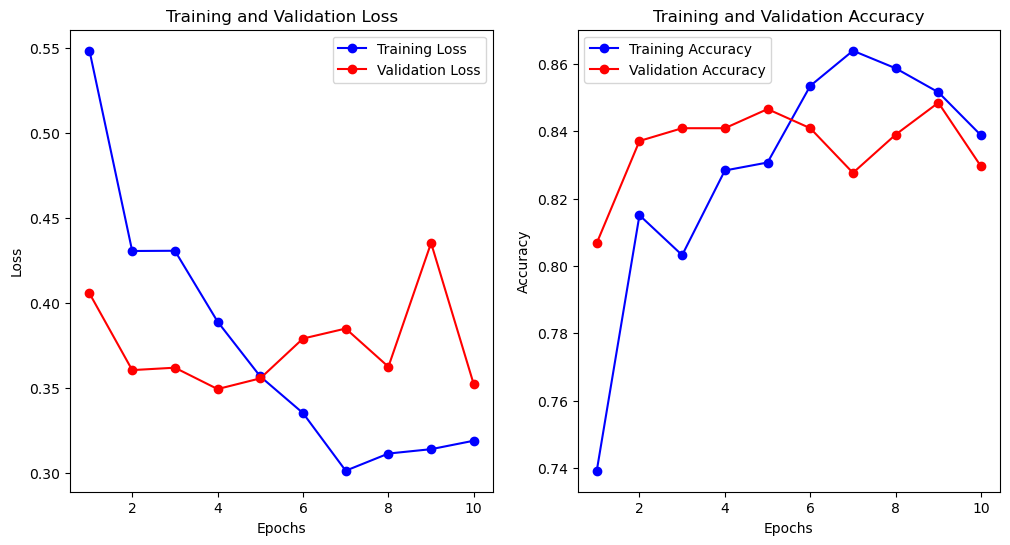

In [19]:
# Learning Curve
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
train_accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Evaluate model on training set
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)

# For binary classification, adjust how you calculate predictions
train_predictions = (model.predict(x_train) > 0.5).astype("int32").flatten()
val_predictions = (model.predict(x_val) > 0.5).astype("int32").flatten()
test_predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()

# Ensure shapes are consistent
y_train = y_train.flatten()  # Flatten y_train if it's not already flattened
y_val = y_val.flatten()  # Flatten y_val if it's not already flattened
y_test = y_test.flatten()  # Flatten y_test if it's not already flattened

# Compute the evaluation metrics
train_f1 = f1_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)

val_f1 = f1_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)

test_f1 = f1_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)

# Print results
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

# Print validation metrics
print("Validation F1 Score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)

# Print test metrics
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.8567 - loss: 0.3265
66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step
Training Loss: 0.32335615158081055
Training Accuracy: 0.8563300371170044
Training F1 Score: 0.8539918484775834
Training Precision: 0.8637245392822502
Training Recall: 0.8444760550023708
Validation F1 Score: 0.8403846153846154
Validation Precision: 0.853515625
Validation Recall: 0.8276515151515151
Test F1 Score: 0.8236196319018405
Test Precision: 0.8338509316770186
Test Recall: 0.8136363636363636


In [25]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_model.keras")

# Define the categories dictionary if not defined already
categories = ['benign', 'malignant']
label_dict = {i: category for i, category in enumerate(categories)}

# img_path = "dataset/Murmur/M9619.png"
img_path = "dataset/malignant/2.jpg"

# Read the input image (grayscale)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Convert grayscale image to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Resize the image to img_size x img_size
resized_img = cv2.resize(img_rgb, (img_size, img_size))

# Normalize pixel values to range [0, 1]
normalized_img = resized_img / 255.0

# Reshape input for model prediction
input_img = normalized_img.reshape(-1, img_size, img_size, 3)  # Reshape input for model prediction

# Make a prediction
prediction = best_model.predict(input_img)

# Get the predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class = label_dict[predicted_class_index]

# Print the predicted class label
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Predicted Class: malignant
